In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import networkx as nx

from tensorflow import keras
from tqdm import tqdm
from pathlib import Path

from astropy import units as u
from astropy.coordinates import SkyCoord
from tensorflow.keras.utils import pad_sequences
from dataloader import LSSTSourceDataSet, load, get_augmented_data, get_static_features, ts_length, get_ts_upto_days_since_trigger, ts_flag_value, static_flag_value, augment_ts_length_to_days_since_trigger
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, source_node_label
from vizualizations import make_gif, plot_reliability_diagram, plot_data_set_composition, plot_day_vs_class_score, plot_lc, make_z_plots
from interpret_results import get_conditional_probabilites, save_all_cf_and_rocs, save_leaf_cf_and_rocs, save_all_phase_vs_accuracy_plot
from train_RNN import default_batch_size

from LSST_Source import LSST_Source

In [313]:
# This step takes a while because it has load from disc to memory...
print("Loading testing data from disc...")
test_dir = Path("processed/test")
max_class_count = 12000

X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

Loading testing data from disc...


In [314]:
for i in tqdm(range(len(X_static))):        
    X_static[i] = get_static_features(X_static[i])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 463528/463528 [00:01<00:00, 255836.98it/s]


In [512]:
rare_class = "TDE"

In [513]:
X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
astrophysical_classes_balanced = []

for c in np.unique(astrophysical_classes):

    if c == rare_class:
        idx = list(np.where(np.array(astrophysical_classes) == c)[0])
        
        if len(idx) > max_class_count:
            idx = random.sample(idx, max_class_count)
    
        X_ts_balanced += [X_ts[i] for i in idx]
        X_static_balanced += [X_static[i] for i in idx]
        Y_balanced += [Y[i] for i in idx]
        astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]

In [514]:
model_dir =  "models/lsst_alpha_0.5/"
tree = get_taxonomy_tree()
model = keras.models.load_model(f"{model_dir}/best_model.h5", compile=False)

In [515]:
true_idx = np.where(Y_balanced[0]==1)[0]
true_idx

array([ 0,  1,  5, 18])

In [516]:
N = len(X_static_balanced) # Number of samples
D = 50 # Number of days
days = np.arange(1, D, 1)

In [517]:
L1 = np.zeros((N, D))
L2 = np.zeros((N, D))
L3 = np.zeros((N, D))

In [518]:
for i in days:
    x1, x2, y_true, _ = augment_ts_length_to_days_since_trigger(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, i)
    logits = model.predict([x1, x2], batch_size=12100)
    _, pseudo_probabilities = get_conditional_probabilites(logits, tree)

    print("Day", i)
    L1[:, i] = pseudo_probabilities[:, true_idx[1]]
    L2[:, i] = pseudo_probabilities[:, true_idx[2]]
    L3[:, i] = pseudo_probabilities[:, true_idx[3]]

1/1 [==============================] - 12s 12s/step
Day 1
1/1 [==============================] - 10s 10s/step
Day 2
1/1 [==============================] - 10s 10s/step
Day 3
1/1 [==============================] - 10s 10s/step
Day 4
1/1 [==============================] - 9s 9s/step
Day 5
1/1 [==============================] - 9s 9s/step
Day 6
1/1 [==============================] - 9s 9s/step
Day 7
1/1 [==============================] - 9s 9s/step
Day 8
1/1 [==============================] - 9s 9s/step
Day 9
1/1 [==============================] - 9s 9s/step
Day 10
1/1 [==============================] - 9s 9s/step
Day 11
1/1 [==============================] - 9s 9s/step
Day 12
1/1 [==============================] - 10s 10s/step
Day 13
1/1 [==============================] - 9s 9s/step
Day 14
1/1 [==============================] - 9s 9s/step
Day 15
1/1 [==============================] - 9s 9s/step
Day 16
1/1 [==============================] - 8s 8s/step
Day 17
1/1 [=========================

In [519]:
threshold = 0.90
flag_value = -9

In [520]:
L1_days = []
for i in range(N):
    
    above_threshold = np.where(L1[i, :]>threshold)[0]
    if len(above_threshold) > 0:
        days_to_threshold = above_threshold[0]
        L1_days.append(days_to_threshold)
    # else:
    #     L1_days.append(flag_value)

In [521]:
L2_days = []
for i in range(N):
    
    above_threshold = np.where(L2[i, :]>threshold)[0]
    if len(above_threshold) > 0:
        days_to_threshold = above_threshold[0]
        L2_days.append(days_to_threshold)
    # else:
    #     L2_days.append(flag_value)

In [522]:
L3_days = []
for i in range(N):
    
    above_threshold = np.where(L3[i, :]>threshold)[0]
    if len(above_threshold) > 0:
        days_to_threshold = above_threshold[0]
        L3_days.append(days_to_threshold)
    # else:
    #     L3_days.append(flag_value)

In [523]:
len(L1_days), len(L2_days), len(L3_days)

(11703, 8966, 7705)

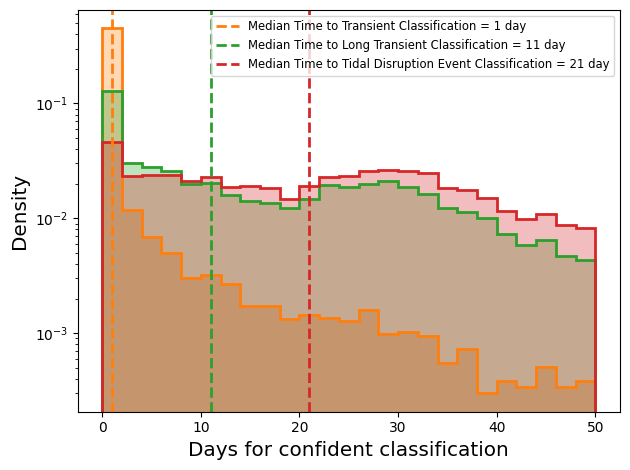

In [524]:
bins = np.arange(0, D+1, 2)

L1_median = int(np.median(L1_days))
L2_median = int(np.median(L2_days))
L3_median = int(np.median(L3_days))

plt.hist(L1_days, color="C1", alpha=0.3, bins=bins, density=True)
plt.hist(L1_days, color="C1", bins=bins, density=True, histtype='step', linewidth=2)

plt.hist(L2_days, color="C2", alpha=0.3, bins=bins, density=True)
plt.hist(L2_days, color="C2", bins=bins, density=True, histtype='step', linewidth=2)

plt.hist(L3_days, color="C3", alpha=0.3, bins=bins, density=True)
plt.hist(L3_days, color="C3", bins=bins, density=True, histtype='step', linewidth=2)


plt.axvline(L1_median, color="C1", linestyle='--', linewidth=2, label=f"Median Time to Transient Classification = {L1_median} day")
plt.axvline(L2_median, color="C2", linestyle='--', linewidth=2, label=f"Median Time to Long Transient Classification = {L2_median} day")
plt.axvline(L3_median, color="C3", linestyle='--', linewidth=2, label=f"Median Time to Tidal Disruption Event Classification = {L3_median} day")

plt.legend(fontsize='small')

plt.xlabel("Days for confident classification", fontsize='x-large')
plt.ylabel("Density",  fontsize='x-large')

plt.yscale('log')
plt.tight_layout()
#plt.savefig(f'{model_dir}/TDE_levels.pdf')

1.0

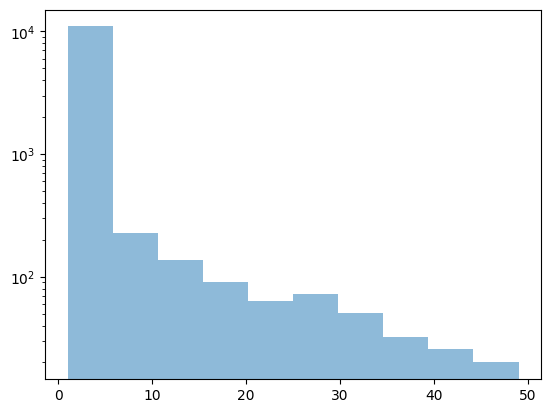

In [525]:
plt.hist(L1_days, alpha=0.5, bins=10)
plt.yscale('log')
np.median(L1_days)

11.0

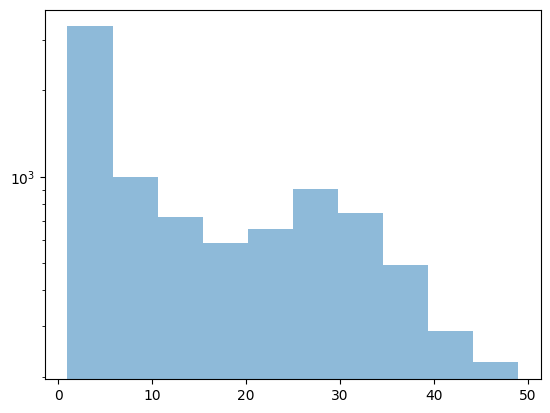

In [526]:
plt.hist(L2_days, alpha=0.5, bins=10)
plt.yscale('log')
np.median(L2_days)

21.0

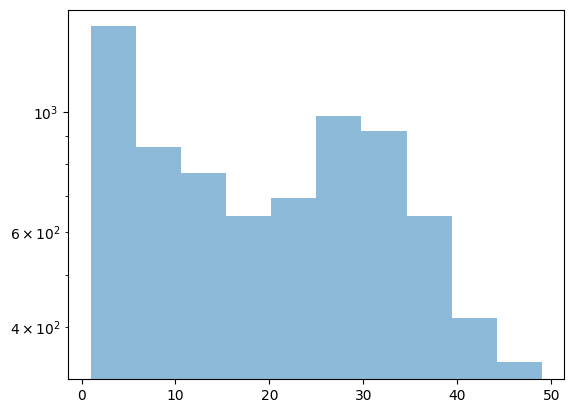

In [527]:
plt.hist(L3_days, alpha=0.5, bins=10)
plt.yscale('log')
np.median(L3_days)

In [528]:
len(L1_days)

11703

In [529]:
len(L2_days)

8966

In [530]:
len(L3_days)

7705